### **Analyze Training Log**

In [33]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [34]:
def parse_log_file(log_file_path):
    """Parse the JSON log file and extract training data."""
    training_steps = []
    validation_steps = []
    hyperparams = {}
    
    with open(log_file_path, 'r') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                event = data.get('event', '')
                
                if event == 'hyperparameters_configured':
                    hyperparams = {k: v for k, v in data.items() if k not in ['event', 'timestamp']}
                
                elif event == 'training_step':
                    training_steps.append({
                        'step': data.get('step', 0),
                        'loss': data.get('loss', 0),
                        'elapsed_time': data.get('elapsed_time', 0),
                        'epoch': (data.get('step', 0) - 1) // 134 + 1  # 134 batches per epoch
                    })
                
                elif event == 'validation_step':
                    validation_steps.append({
                        'step': data.get('step', 0),
                        'loss': data.get('loss', 0),
                        'elapsed_time': data.get('elapsed_time', 0),
                        'epoch': (data.get('step', 0) - 1) // 134 + 1
                    })
                    
            except json.JSONDecodeError:
                continue
    
    return training_steps, validation_steps, hyperparams


log_file = "../mainrun/logs/mainrun.log"
# Parse log file
training_steps, validation_steps, hyperparams = parse_log_file(log_file)

# Convert to DataFrames
train_df = pd.DataFrame(training_steps)
val_df = pd.DataFrame(validation_steps)


#### **Training and Validation Loss Over Time**

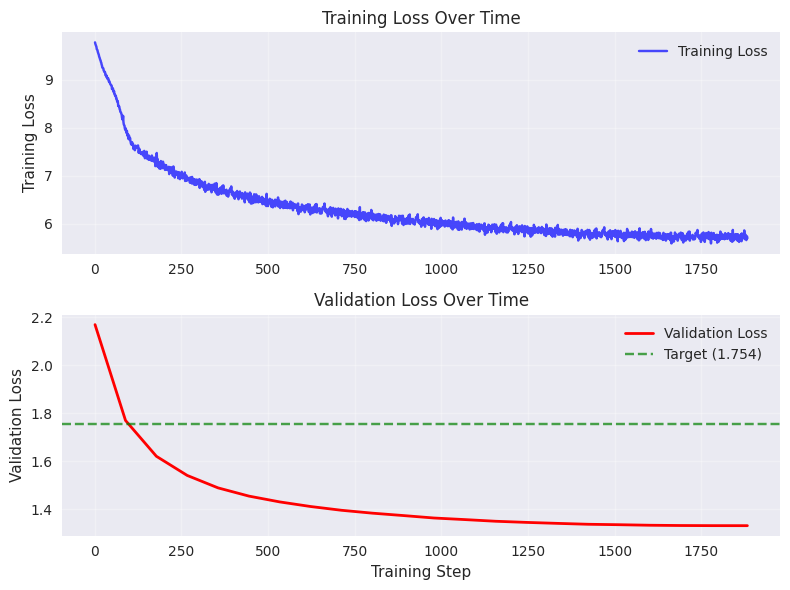

In [35]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Training and Validation Loss Over Time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Training loss
ax1.plot(train_df['step'], train_df['loss'], 'b-', alpha=0.7, label='Training Loss')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Over Time')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Validation loss
ax2.plot(val_df['step'], val_df['loss'], 'r-', linewidth=2, label='Validation Loss')
ax2.axhline(y=1.754, color='g', linestyle='--', alpha=0.7, label='Target (1.754)')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Over Time')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

#### **Training and Validation Loss by Epoch**

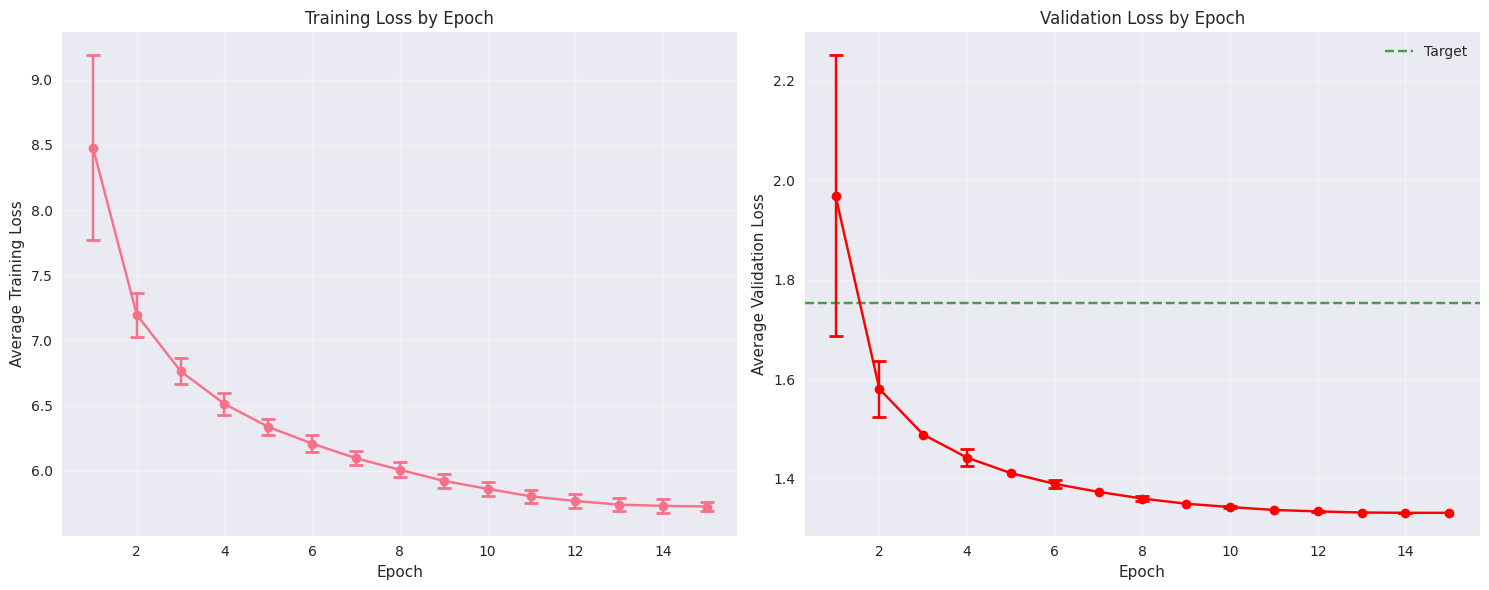

In [36]:
# Loss by Epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training loss by epoch
train_by_epoch = train_df.groupby('epoch')['loss'].agg(['mean', 'std']).reset_index()
ax1.errorbar(train_by_epoch['epoch'], train_by_epoch['mean'],
            yerr=train_by_epoch['std'], fmt='o-', capsize=5, capthick=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Training Loss')
ax1.set_title('Training Loss by Epoch')
ax1.grid(True, alpha=0.3)

# Validation loss by epoch
val_by_epoch = val_df.groupby('epoch')['loss'].agg(['mean', 'std']).reset_index()
ax2.errorbar(val_by_epoch['epoch'], val_by_epoch['mean'],
            yerr=val_by_epoch['std'], fmt='o-', capsize=5, capthick=2, color='red')
ax2.axhline(y=1.754, color='g', linestyle='--', alpha=0.7, label='Target')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Validation Loss')
ax2.set_title('Validation Loss by Epoch')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

#### **Training vs Validation Loss Comparision**

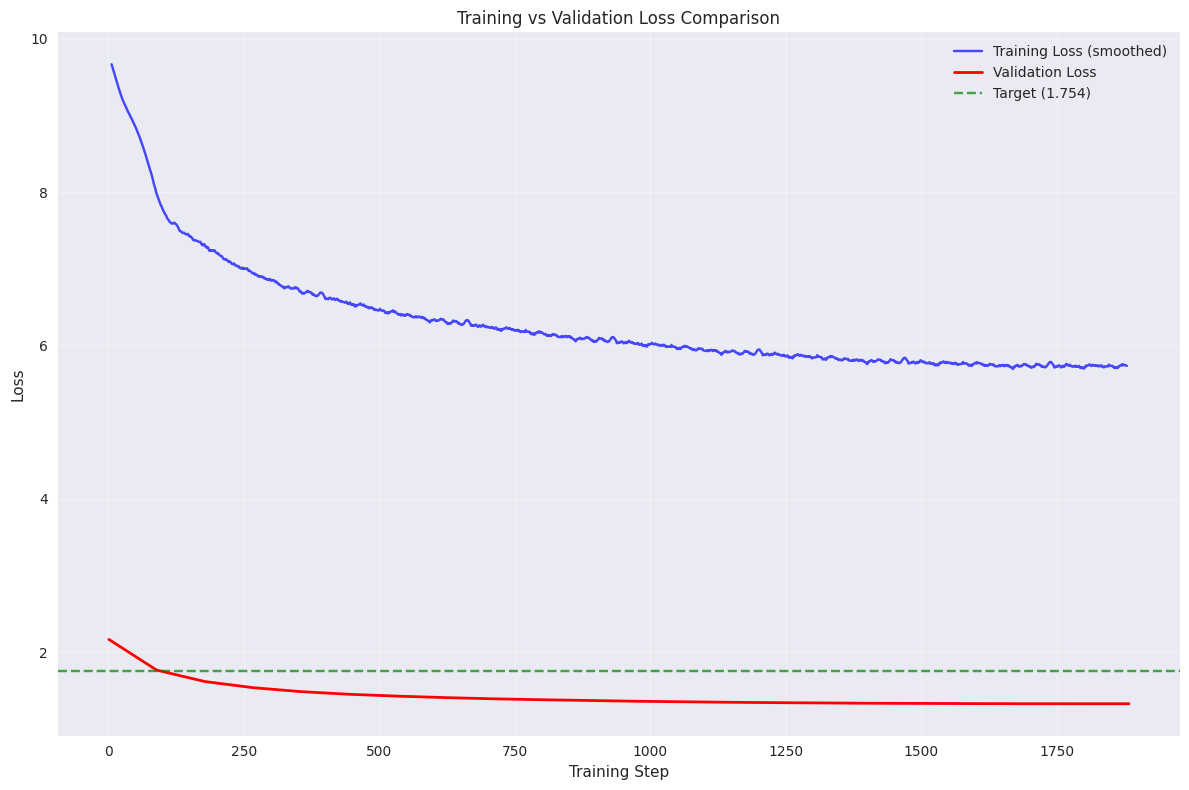

In [37]:
# Training vs Validation Loss Comparison
plt.figure(figsize=(12, 8))

# Smooth the training loss for better visualization
train_smooth = train_df['loss'].rolling(window=10, center=True).mean()

plt.plot(train_df['step'], train_smooth, 'b-', alpha=0.7, label='Training Loss (smoothed)')
plt.plot(val_df['step'], val_df['loss'], 'r-', linewidth=2, label='Validation Loss')
plt.axhline(y=1.754, color='g', linestyle='--', alpha=0.7, label='Target (1.754)')

plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### **Loss Distribution Analysis**

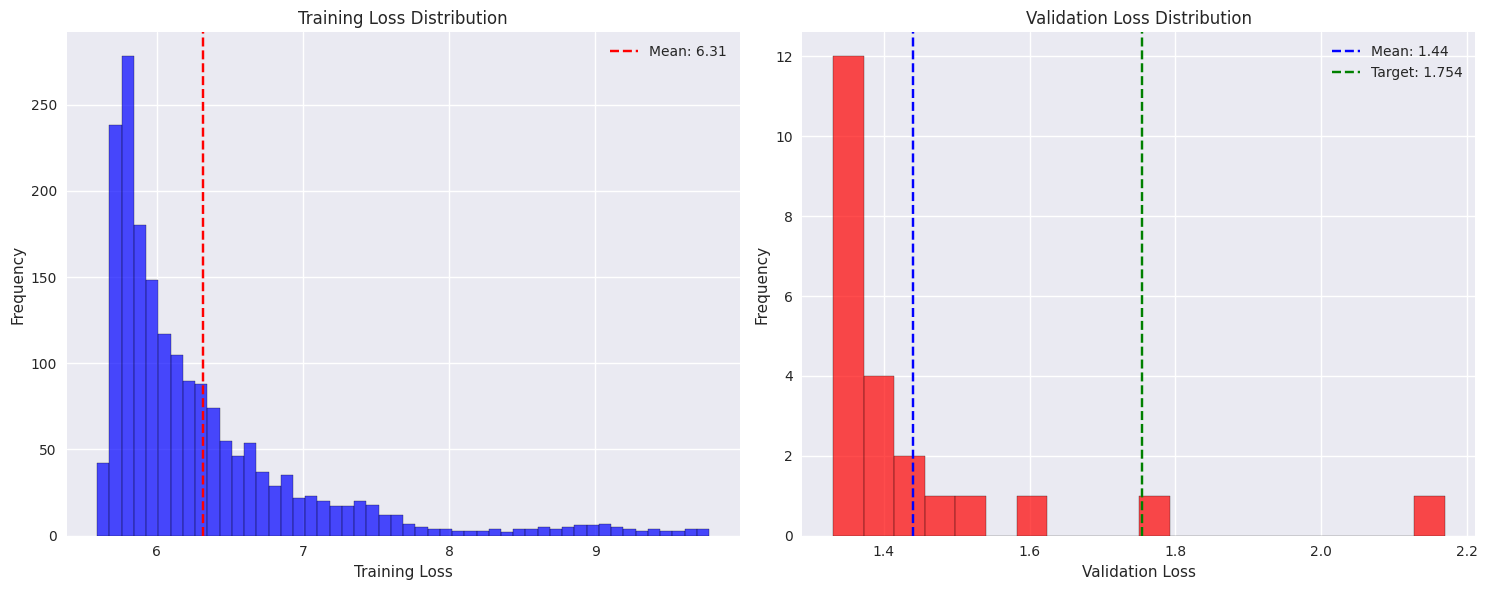

In [38]:
# Loss Distribution Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training loss distribution
ax1.hist(train_df['loss'], bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(train_df['loss'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["loss"].mean():.2f}')
ax1.set_xlabel('Training Loss')
ax1.set_ylabel('Frequency')
ax1.set_title('Training Loss Distribution')
ax1.legend()

# Validation loss distribution
ax2.hist(val_df['loss'], bins=20, alpha=0.7, color='red', edgecolor='black')
ax2.axvline(val_df['loss'].mean(), color='blue', linestyle='--', label=f'Mean: {val_df["loss"].mean():.2f}')
ax2.axvline(1.754, color='green', linestyle='--', label='Target: 1.754')
ax2.set_xlabel('Validation Loss')
ax2.set_ylabel('Frequency')
ax2.set_title('Validation Loss Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

#### **Training Progress Analysis**

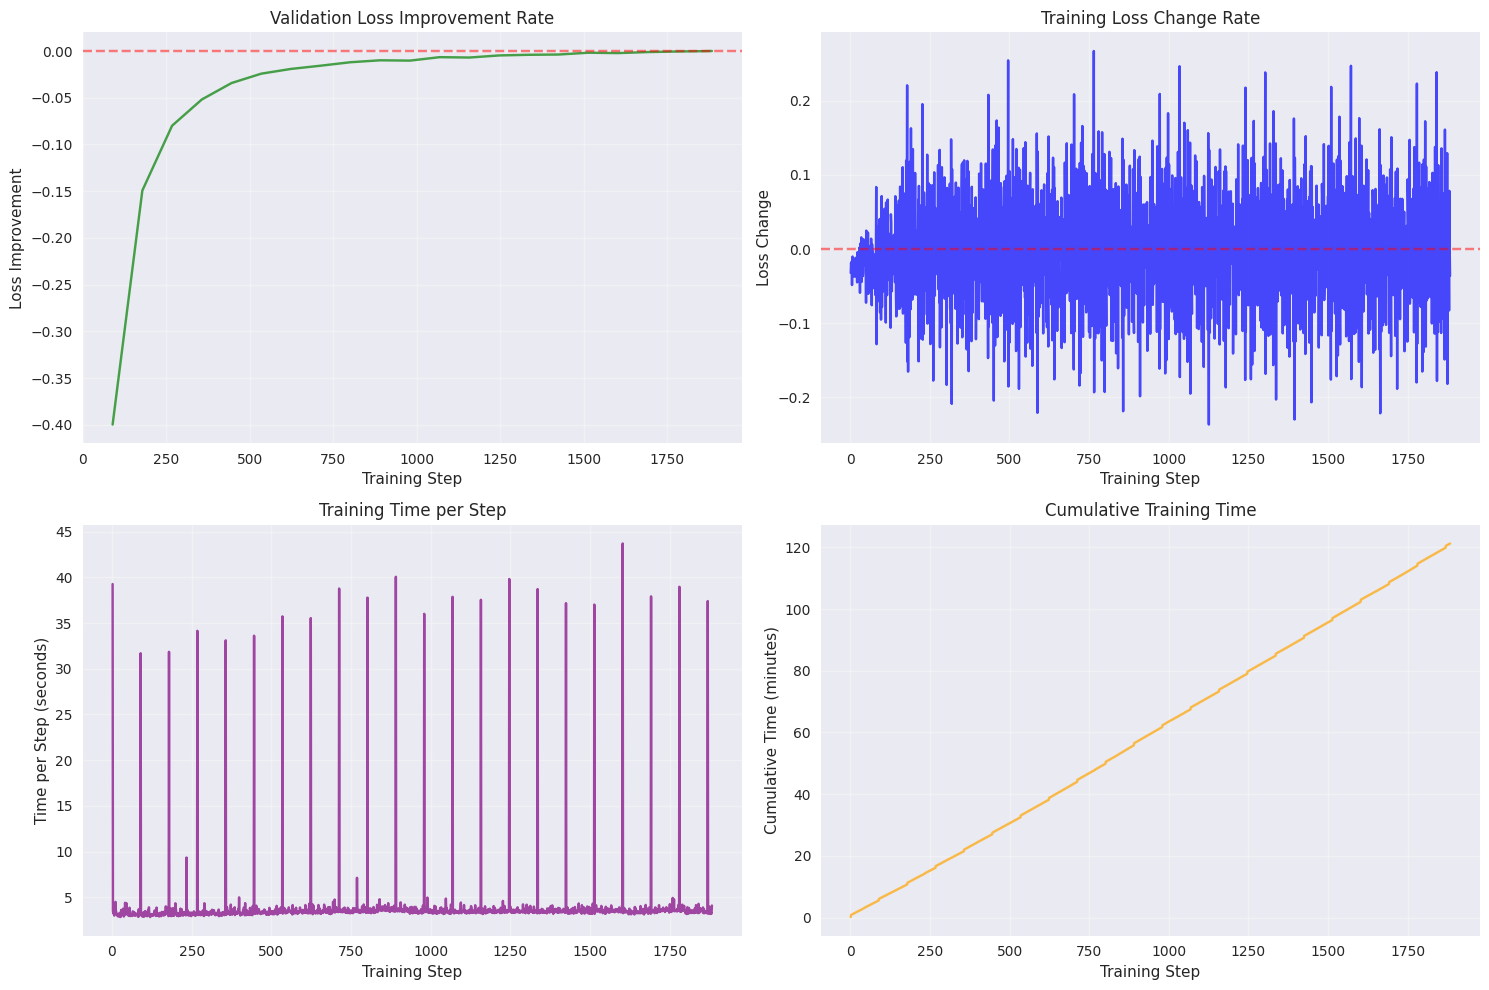

In [39]:
# Training Progress Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss improvement rate
val_loss_diff = val_df['loss'].diff()
ax1.plot(val_df['step'][1:], val_loss_diff[1:], 'g-', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss Improvement')
ax1.set_title('Validation Loss Improvement Rate')
ax1.grid(True, alpha=0.3)

# Training speed (loss per step)
train_loss_diff = train_df['loss'].diff()
ax2.plot(train_df['step'][1:], train_loss_diff[1:], 'b-', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Loss Change')
ax2.set_title('Training Loss Change Rate')
ax2.grid(True, alpha=0.3)

# Time per step
time_per_step = train_df['elapsed_time'].diff()
ax3.plot(train_df['step'][1:], time_per_step[1:], 'purple', alpha=0.7)
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Time per Step (seconds)')
ax3.set_title('Training Time per Step')
ax3.grid(True, alpha=0.3)

# Cumulative training time
ax4.plot(train_df['step'], train_df['elapsed_time'] / 60, 'orange', alpha=0.7)
ax4.set_xlabel('Training Step')
ax4.set_ylabel('Cumulative Time (minutes)')
ax4.set_title('Cumulative Training Time')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### **Learning Rate Visualization**

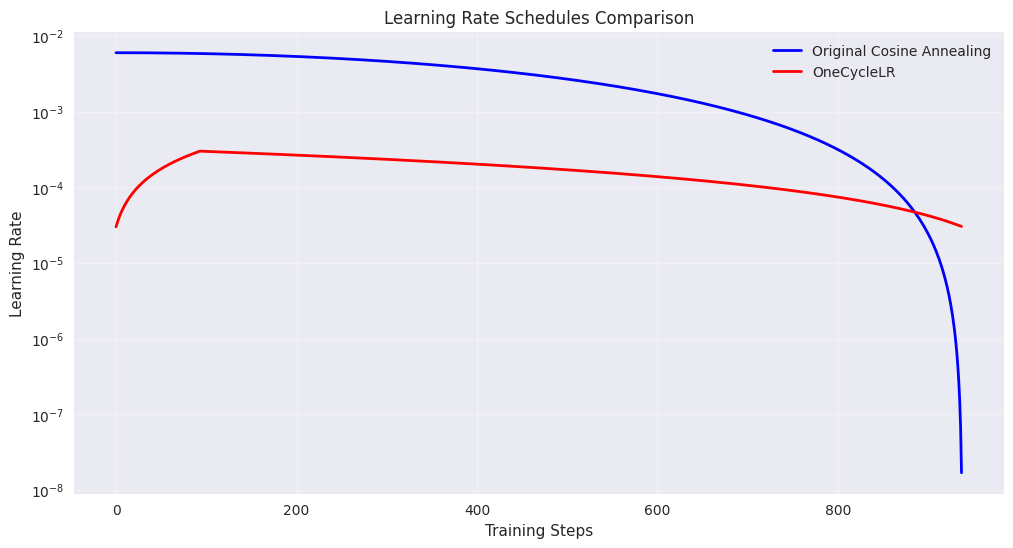

In [40]:
import numpy as np

# Parameters
max_steps = 938
steps = np.arange(max_steps)

# Original Cosine Annealing
lr_original = 6e-3 * (1 + np.cos(np.pi * steps / max_steps)) / 2

# Your OneCycleLR
warmup_steps = max_steps // 10
max_lr = 3e-4
initial_lr = max_lr / 10

lr_onecycle = np.zeros(max_steps)
for i in range(max_steps):
    if i < warmup_steps:
        # Warmup phase
        lr_onecycle[i] = initial_lr + (max_lr - initial_lr) * i / warmup_steps
    else:
        # Annealing phase
        progress = (i - warmup_steps) / (max_steps - warmup_steps)
        lr_onecycle[i] = max_lr - (max_lr - initial_lr) * progress

plt.figure(figsize=(12, 6))
plt.plot(steps, lr_original, 'b-',
         label='Original Cosine Annealing', linewidth=2)
plt.plot(steps, lr_onecycle, 'r-', label='OneCycleLR', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedules Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()